# Ice Station Zebra Pipeline Demo

This demonstration showcases the complete Ice Station Zebra ML pipeline capabilities through CLI commands. 

**Target Audience:** Developer teams and future team members who want to understand our design decisions, 
trade-offs, and flexible experimentation capabilities.

**You'll learn how to:**
- Run our training pipeline end-to-end in three lines of code
- Swap between different modelling paradigms
- Reproduce runs and inspect the outputs
- Evaluate the performance of the models in line with community standards on sea ice forecasting

<div class="alert alert-danger">

If you want to run this notebook, you will need a **CDS account** in order to download the ERA5 weather data. Details of how to set this up can be found [here](https://cds.climate.copernicus.eu/how-to-api).

You will also need a **Weights & Biases account** to log the training runs. You can sign up for a free account [here](https://wandb.ai/). Once you have an account, you will need to set up your API key; instructions for do so can be found [here](https://docs.wandb.ai/models/quickstart#python-notebook).

</div>

## Notebook Structure

[**Section 1: End-to-End Training**](#section-1-end-to-end-training-pipeline)
- Run a full zebra pipeline end-to-end using a minimal configuration & data
- Inspect training artifacts and see evaluation outputs

[**Section 2: Model Flexibility**](#section-2-model-flexibility)
- Switch between Encode-Process-Decode paradigm and standalone persistence model
- Explore Encoder module functionality (Multimodality)

[**Section 3: Full flexibility - Advanced Example**](#section-3-full-flexibility-advanced-example)
- Write or adapt config files to change pipeline behavior
- use anemoi functionality to fetch and inspect standard datsets
- see our pipeline data checks and validation in action
- Evaluate and compare model performance using a pretrained model checkpoint
- Explore different plotting formats and metrics

# Section 1: End-to-End Training Pipeline

In this section, we'll demonstrate the complete training pipeline using a simple **UNet model with a naive encoder / decoder** (more details of this can be found below in [section 2](#section-2-model-flexibility)). 
The dataset contains sea ice concentration data (OSISAF) and corresponding atmospheric data (ERA5).
We don't expect the model to do well as we are only training for 10 epochs, and won't do any hyperparameter optimisation. However, it will give us a sense of the pipeline.

You can install the repo by running the following commands in your terminal:

```bash
git clone https://github.com/alan-turing-institute/ice-station-zebra
cd ice-station-zebra
pip install .
```

In [1]:
# load in the relevant packages
import os

### Environment Verification

Let's verify that our zebra cli tools are available and working.

To run this notebook, you'll need a kernel (e.g. conda or .venv) with the ice_station_zebra repo and jupyter installed.

In [2]:
!zebra --help

                                                                                
 Usage: zebra [OPTIONS] COMMAND [ARGS]...                                       
                                                                                
 Entrypoint for zebra application commands                                      
                                                                                
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --install-completion            Install completion for the current shell.    │
│ --show-completion               Show completion for the current shell, to    │
│                                 copy it or customize the installation.       │
│ --help                -h        Show this message and exit.                  │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Commands ────────────────

### Download the dataset for running the model

<div class="alert alert-danger"> 

N.B. to run this minimal example requires you to have signed up to access the ERA5 data. Details on how to do so can be found [here](https://cds.climate.copernicus.eu/how-to-api).

You will also need a **Weights & Biases account** to log the training runs. You can sign up for a free account [here](https://wandb.ai/). Once you have an account, you will need to set up your API key; instructions for do so can be found [here](https://docs.wandb.ai/models/quickstart#python-notebook).

</div>

The model will download a set of ERA5 weather data, and OSISAF sea ice concentration (SIC) data over 2017-2019. The details of this data are specified in `demo_nb.yaml`. (Details about how these config files work will be covered in a later section.) 

If the data is already present, a summary of the dataset will be printed (it will not be downloaded again). This same summary can be created by running `zebra datasets inspect`.

**This assumes you have a folder called `my_data/` in the root of the repo.**

In [3]:
!zebra datasets create --config-name=demo_nb.yaml

Working on samp-sicsouth-osisaf-25k-2017-2019-24h-v1.
Inspecting dataset samp-sicsouth-osisaf-25k-2017-2019-24h-v1 at /Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/my_data/data/anemoi/samp-sicsouth-osisaf-25k-2017-2019-24h-v1.zarr.
📦 Path          : /Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/my_data/data/anemoi/samp-sicsouth-osisaf-25k-2017-2019-24h-v1.zarr
🔢 Format version: 0.30.0

📅 Start      : 2017-01-01 00:00
📅 End        : 2019-01-31 00:00
⏰ Frequency  : 1d
🚫 Missing    : 0
🌎 Resolution : None
🌎 Field shape: [432, 432]

📐 Shape      : 761 × 1 × 1 × 186,624 (541.8 MiB)
💽 Size       : 51.5 MiB (51.5 MiB)
📁 Files      : 811

   Index │ Variable │ Min │ Max │      Mean │    Stdev
   ──────┼──────────┼─────┼─────┼───────────┼─────────
       0 │ ice_conc │   0 │   1 │ 0.0715942 │ 0.237269
   ──────┴──────────┴─────┴─────┴───────────┴─────────

  2025-10-16 16:56:11.459960 : initialised
  2025-10-16 16:56:11.460823 : tmp_statistics_initialised (version=3)
 

### Train the model

The next command will train a simple UNet model for sea ice concentration forecasting, and the training will run for 10 epochs. The options used for training this model are specified in `demo_nb.yaml`. 

In [4]:
!zebra train --config-name=demo_nb.yaml

# save the file path
path_unet_train = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

Found 2 dataset_groups.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_151943-1l41xsy3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fiery-brook-95
wandb: ⭐️ View project at https://wandb.ai/turing-seaice/naive-unet-naive
wandb: 🚀 View run at https://wandb.ai/turing-seaice/naive-unet-naive/runs/1l41xsy3
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
Starting training for 10 epochs.

  | Name      | Type               | Params | Mode 
-------------------------------

### Evaluate the model

Finally the model is evaluated using the checkpoint, saved during the training run. The results are then logged to Weights & Biases. (This will log them to your default WandB project. Within the Sea Ice project there is a wandb account for the Sea Ice project where results are usually logged.)

In [9]:
# get the path to the checkpoint file
ckpt_unet = os.path.join(path_unet_train, "checkpoints/epoch=9-step=1810.ckpt")

!zebra evaluate --config-name=demo_nb.yaml --checkpoint="{ckpt_unet}"

# save the file path
path_unet_eval = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

Found 2 dataset_groups.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_152946-ycqpgckb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run naive-unet-naive-20251110_152946
wandb: ⭐️ View project at https://wandb.ai/turing-seaice/leaderboard
wandb: 🚀 View run at https://wandb.ai/turing-seaice/leaderboard/runs/ycqpgckb
Loaded test dataset with 27 samples between 2019-01-01T00:00:00 and 2019-01-31T00:00:00.
Testing DataLoader 0

We can then check the predictions from this model. (N.b. as it is only run for a small number of epochs on a limited dataset, the results are not great.)

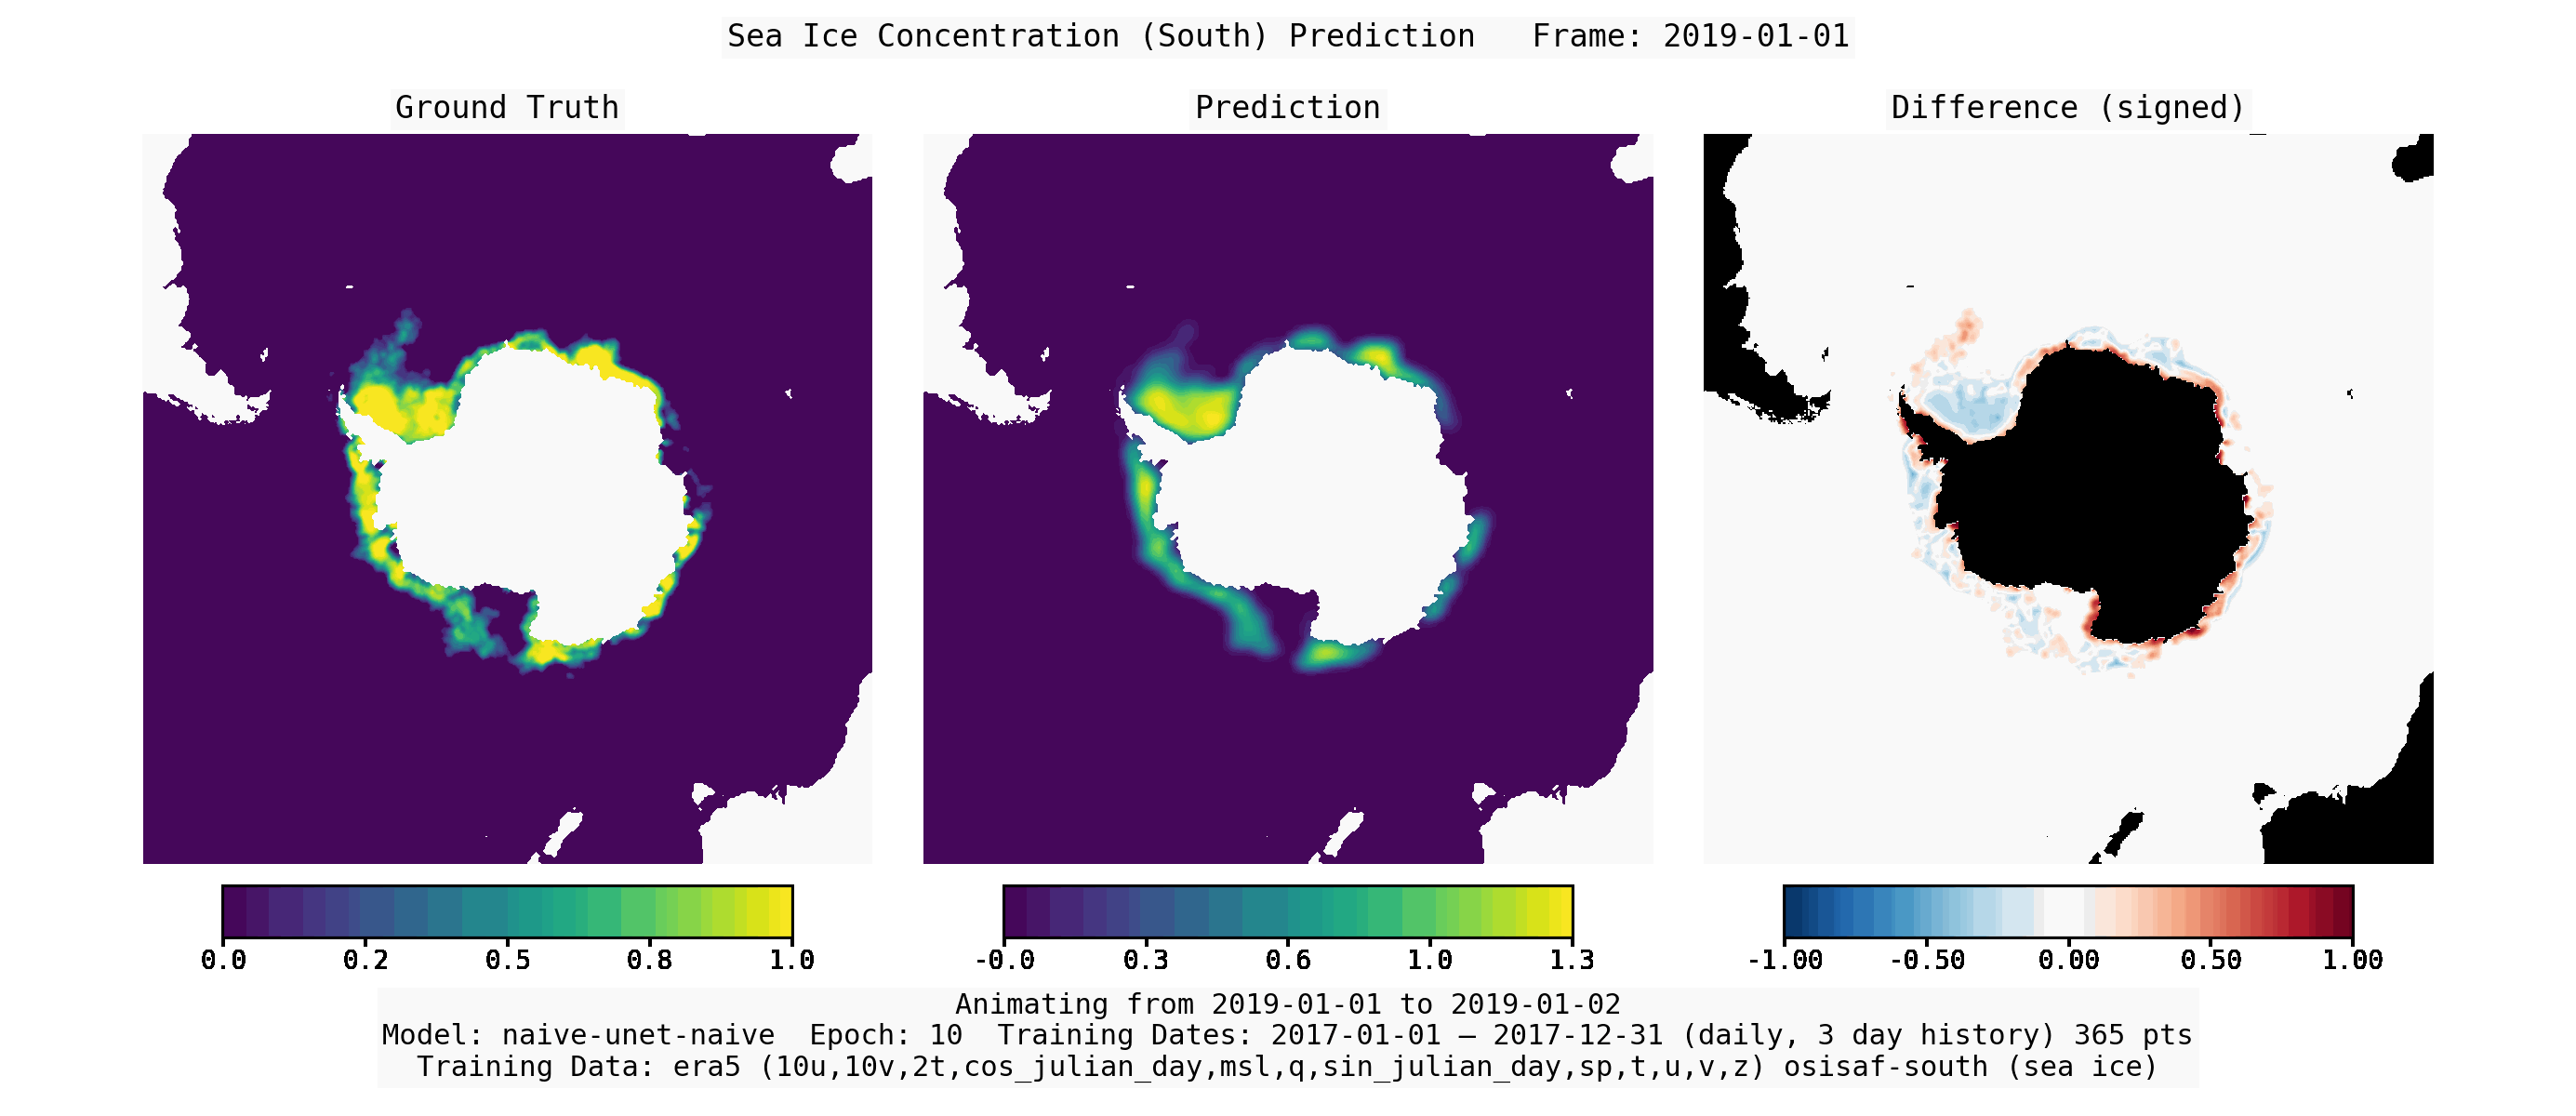

In [10]:
import os
from IPython.display import Image

# extract the file name (it has a random string on the end)
img_unet = os.path.join(path_unet_eval, "files/media/videos")
file = os.path.join(img_unet, os.listdir(img_unet)[0])

Image(filename=file)

# Section 2: Model Flexibility

In this section, we'll demonstrate how easy it is to switch between different model architectures.
We'll also show the difference between standalone models and processor models.

The conceptually simpler model type is a standalone model, which takes in the input data and directly outputs the prediction. These models are less flexible, as they have to be specifically coded to handle new input / output data. Consequently a separate instance of the model is likely to be needed for each input / output combination. However, the input variables are available without transformation.  

![pipeline_standalone](../docs/assets/pipeline-standalone.png)

The more complex model type is processor model, which uses an encode-process-decode paradigm. Here, the input data is first encoded into a latent representation of fixed dimensions, which is then processed by a core model, before being decoded back into the output space. This allows for more flexibility in terms of input and output variables, as well as the ability to use different types of models for each component.

![pipeline_encode_process_decode](../docs/assets/pipeline-encode-process-decode.png)

## Using an alternative processor model

The initial model we ran, the `naive_unet_naive` model, is an example of a processor model. It uses a naive encoder, to convert the input variables into the latent space. A UNet model is then run on the latent space, before a naive encoder extracts the SIC predictions. 

In this example, we switch the `naive_unet_naive` model for the alternative `naive_vit_naive` model, which still uses a naive enocder / decoder, but replaces the UNet model with a Vision Transformer (ViT).

In [11]:
!zebra train --config-name=demo_nb.yaml model=naive_vit_naive 

# save the file path
path_vit_train = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

Found 2 dataset_groups.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_153120-stzsfjti
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run revived-energy-17
wandb: ⭐️ View project at https://wandb.ai/turing-seaice/naive-vit-naive
wandb: 🚀 View run at https://wandb.ai/turing-seaice/naive-vit-naive/runs/stzsfjti
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
Starting training for 10 epochs.

  | Name      | Type               | Params | Mode 
------------------------------

In [12]:
# get the path to the checkpoint file
ckpt_vit = os.path.join(path_vit_train, "checkpoints/epoch=9-step=1810.ckpt")

!zebra evaluate --config-name=demo_nb.yaml --checkpoint="{ckpt_vit}"

# save the file path
path_vit_eval = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

Found 2 dataset_groups.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_153647-zb0hp63k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run naive-vit-naive-20251110_153647
wandb: ⭐️ View project at https://wandb.ai/turing-seaice/leaderboard
wandb: 🚀 View run at https://wandb.ai/turing-seaice/leaderboard/runs/zb0hp63k
Loaded test dataset with 27 samples between 2019-01-01T00:00:00 and 2019-01-31T00:00:00.
Testing DataLoader 0:

The results are logged to [Weights & Biases](https://wandb.ai/), but they can also be viewed locally. When inspecting the predictions of the model using a vision transformer architecture you can notice a checkerboard pattern, an artefact of the patch embedding approach this model uses, which occurs when the models are not sufficiently trained.

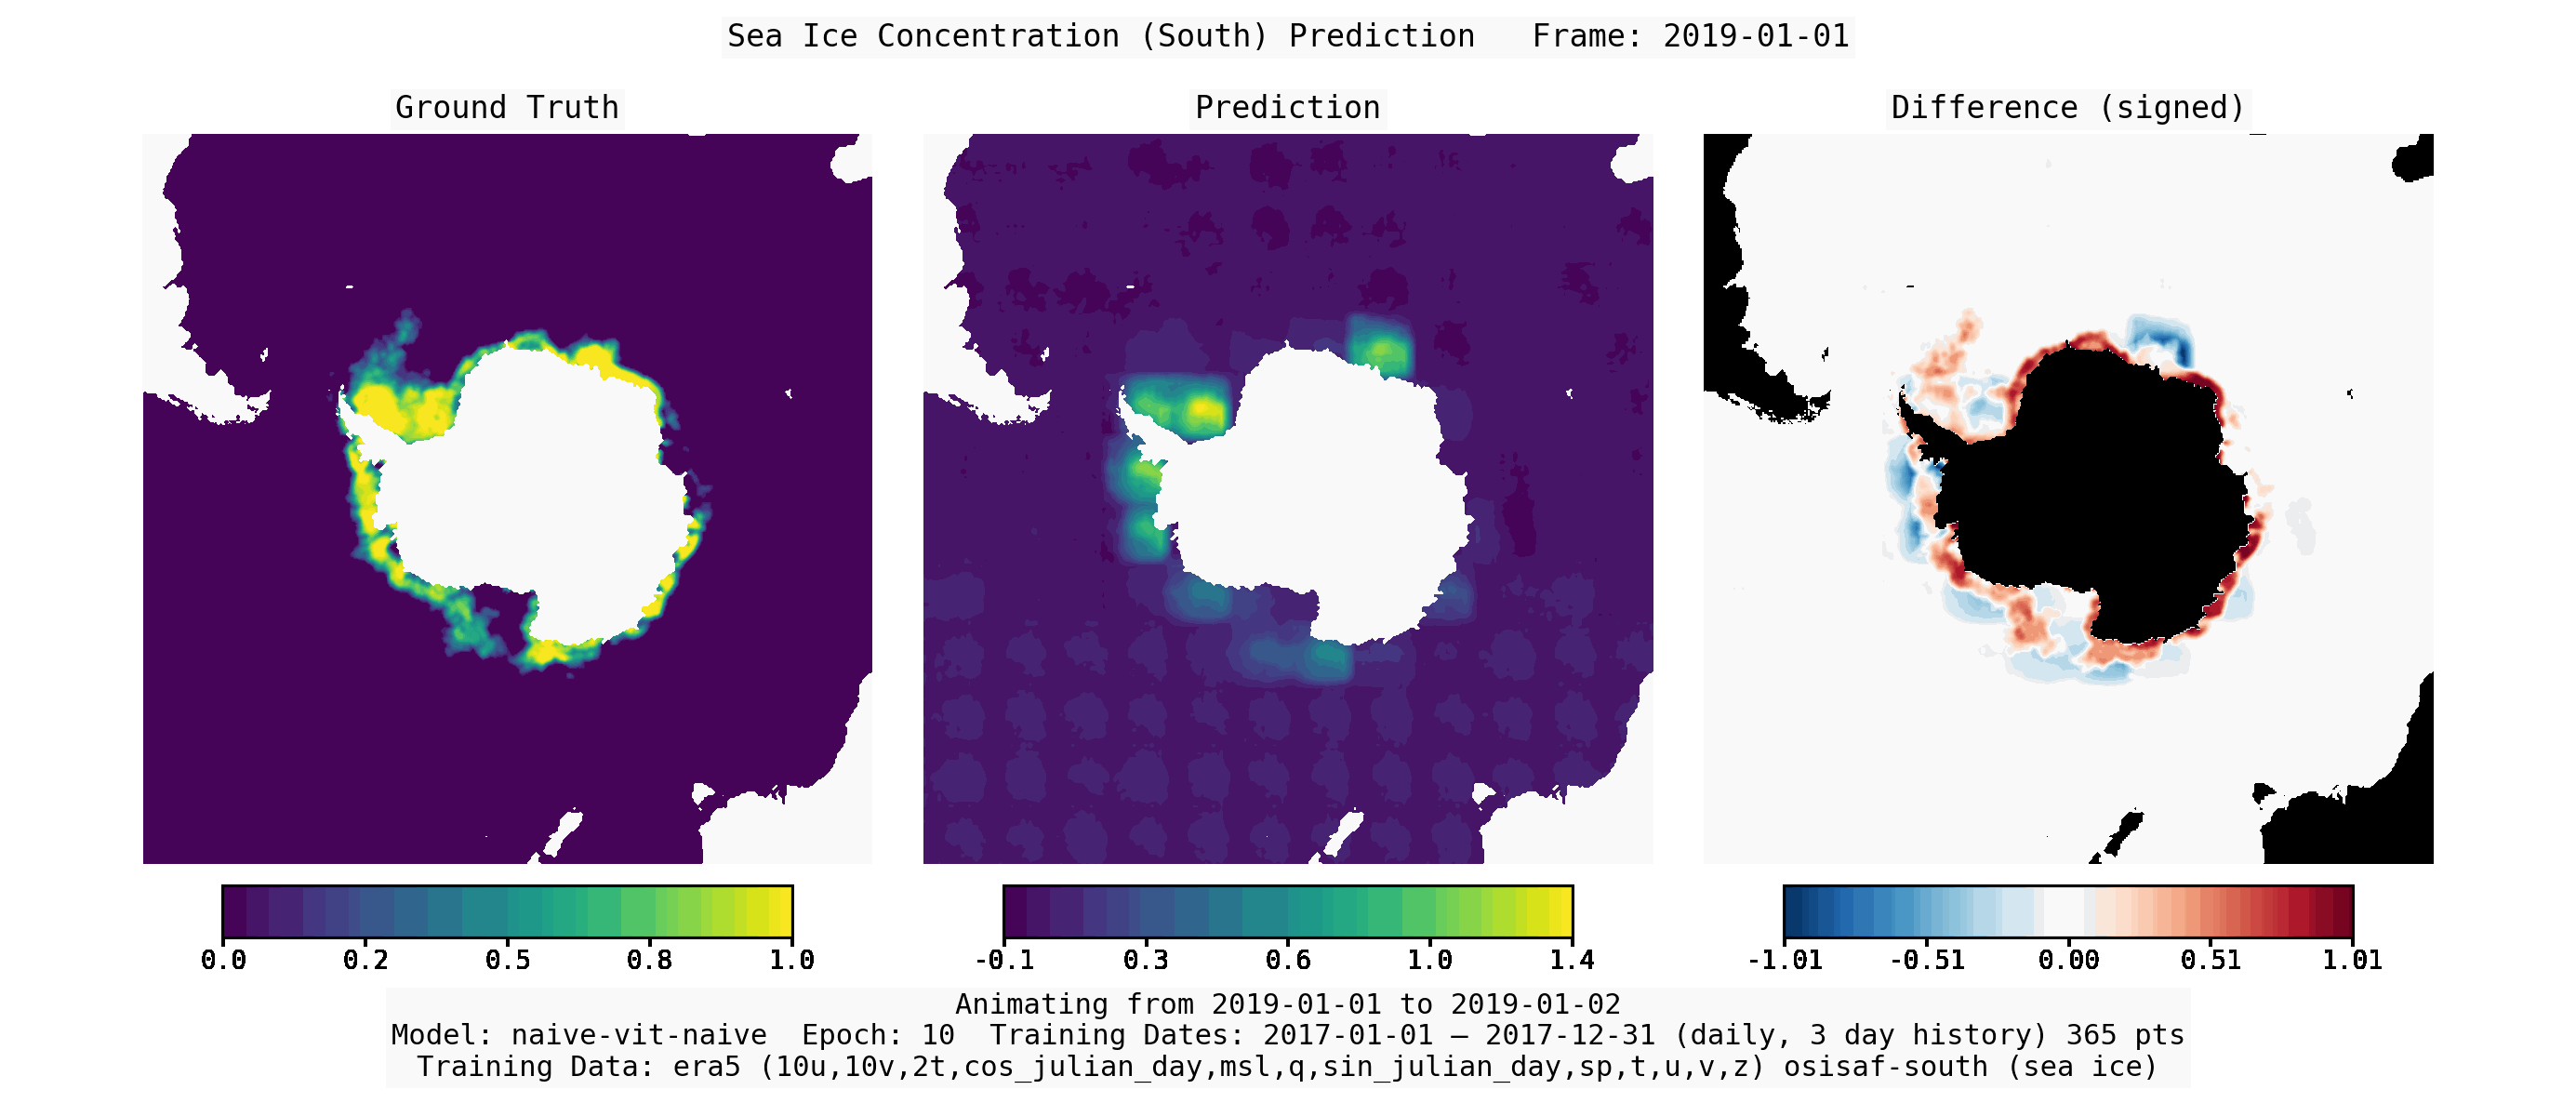

In [13]:
# extract the file name (it has a random string on the end)
img_vit = os.path.join(path_vit_eval, "files/media/videos")
file = os.path.join(img_vit, os.listdir(img_vit)[0])

Image(filename=file)


There is also the option to replace the naive encoder / decoder with convolutional neural networks (CNNs), however these struggle to train on a laptop, so we won't demonstrate them here. If you want to test them out, just set the model to be `cnn_unet_cnn` or `cnn_vit_cnn` in the config file.

## Standalone persistence model

As mentioned above, an alternative form of model doesn't use an encoder / decoder architecture. We can demonstrate this with a `persistence model` which simply outputs the last input frame as the prediction.

In this case, as well as specifying the model type as `persistence`, we also need to specify a different training config, as the persistence model doesn't need training over multiple epochs.

In [16]:
!zebra train --config-name=demo_nb.yaml model=persistence train=persistence

# save the file path
path_pers_train = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

Found 2 dataset_groups.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_154254-imn329sm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fearless-rain-71
wandb: ⭐️ View project at https://wandb.ai/turing-seaice/persistence
wandb: 🚀 View run at https://wandb.ai/turing-seaice/persistence/runs/imn329sm
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
Starting training for 10 epochs.
/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv/lib/python3.11/site-package

In [18]:
ckpt_pers = os.path.join(path_pers_train, "checkpoints/epoch=10-step=0.ckpt")

!zebra evaluate --config-name=persistence.yaml ++base_path="../my_data" --checkpoint="{ckpt_pers}"

# save the file path
path_pers_eval = os.path.join("../my_data/training/wandb/", sorted(os.listdir("../my_data/training/wandb/"))[-1])

/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/.venv/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:94: The state dict in PosixPath('/Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/my_data/training/wandb/run-20251110_154254-imn329sm/checkpoints/epoch=10-step=0.ckpt') contains no parameters.
Found 2 dataset_groups.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Assigning 9 workers for data loading.
wandb: Currently logged in as: ifenton (turing-seaice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ creating run (0.7s)
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in ../my_data/training/wandb/run-20251110_154700-9kaxez

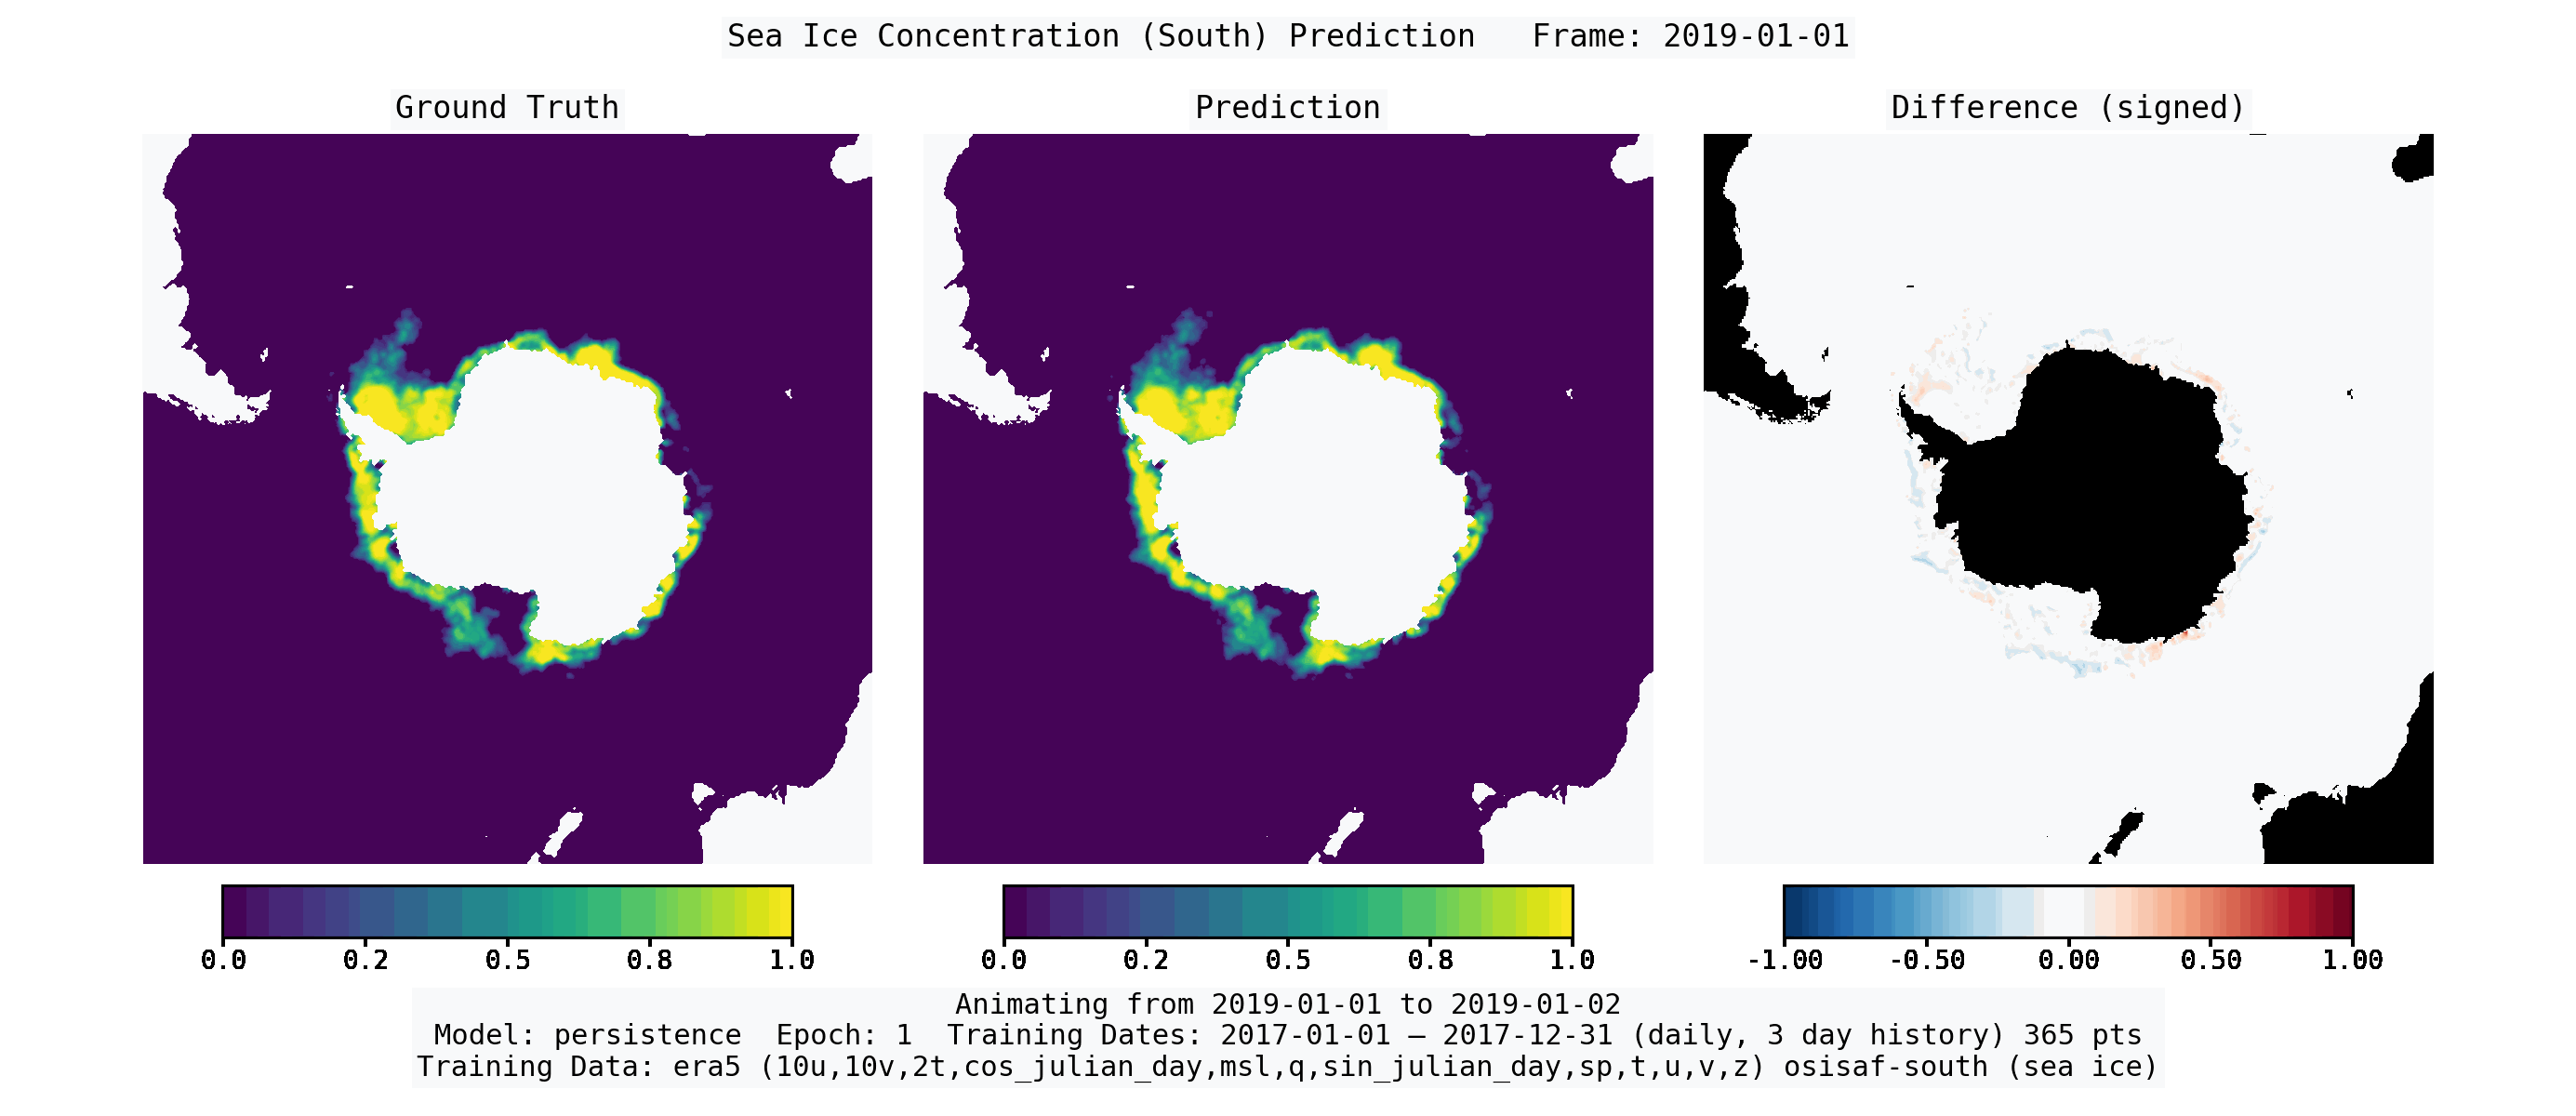

In [19]:
# extract the file name (it has a random string on the end)
img_pers = os.path.join(path_pers_eval, "files/media/videos")
file = os.path.join(img_pers, os.listdir(img_pers)[0])

Image(filename=file)

# Section 3: Full flexibility (Advanced Example)

This section shows how to adapt the different parts of the model pipeline to your needs. We will look in to the config files that are the basis of the pipeline, and we will show how to create your own config file to give you full control over the model training. 

The pipeline uses hydra, which is a powerful configuration management tool. More details can be found [here](https://hydra.cc/docs/intro/). 

These config files are logged as part of the WandB run, so it is easy to go back and check exactly what settings were used for each run, or to reproduce a run.

## The base config file

So far in this notebook, we've mostly used the `demo_nb.yaml` config file. We can have a look at the contents of this file to see what options it is using.

In [20]:
!cat ../ice_station_zebra/config/demo_nb.yaml

defaults:
  - base
  - _self_

train:
  trainer:
    max_epochs: 10

loggers:
  wandb:
    entity: null

base_path: ../my_data
antialias_val: false


As you can see here, the defaults section points to the `base.yaml` config file, which contains the main options for the pipeline. There are then some specific options for how many epochs to train for, and where to save the data.

So lets have a look at the `base.yaml` file.

In [21]:
!cat ../ice_station_zebra/config/base.yaml

defaults:
  - datasets:
    - samp_sicsouth_osisaf_25k_2017_2019_24h_v1
    - samp_weathersouth_era5_0p5_2017_2019_24h_v1
  - evaluate: default
  - loggers:
    - wandb
  - model: naive_unet_naive
  - predict: osisaf-south
  - split: sample_dataset
  - train: default
  - _self_

base_path: /bask/projects/v/vjgo8416-ice-frcst/shared/zebra/
antialias_val: true # Global setting for antialiasing in encoders/decoders - fixing Mac bug


There are lots more options under the defaults section here, for specifying a range of options such as the datasets, or the model to use. Some of these options should also look familiar from the `demo_nb.yaml` file. For example, under `loggers`, we can see `wandb` specified as the logger to use.

In [42]:
!ls ../ice_station_zebra/config/*/

../ice_station_zebra/config/datasets/:
demo_sicnorth_osisaf_25k_2017_2019_24h_v1.yaml
demo_weathernorth_era5_0p5_2017_2019_24h_v1.yaml
full_sicnorth_osisaf_25k_1979_2024_24h_v1.yaml
full_sicsouth_osisaf_25k_1979_2024_24h_v1.yaml
full_weathernorth_era5_0p5_1979_2024_24h_v1.yaml
full_weathersouth_era5_0p5_1979_2024_24h_v1.yaml
naming_convention.txt
nbsamp_sicnorth_osisaf_25k_2003_2003_24h_v1.yaml
nbsamp_sicnorth_osisaf_25k_2010_2010_24h_v1.yaml
nbsamp_sicnorth_osisaf_25k_2018_2018_24h_v1.yaml
nbsamp_weathersouth_era5_0p5_2020_2020_24h_v1.yaml
samp_sicnorth_osisaf_25k_2017_2019_24h_v1.yaml
samp_sicsouth_osisaf_25k_2017_2019_24h_v1.yaml
samp_weathernorth_era5_0p5_2017_2019_24h_v1.yaml
samp_weathersouth_era5_0p5_2017_2019_24h_v1.yaml
test_sicnorth_osisaf_25k_2017_2019_24h_v1.yaml

../ice_station_zebra/config/evaluate/:
callbacks    default.yaml

../ice_station_zebra/config/loggers/:
wandb.yaml

../ice_station_zebra/config/model/:
cnn_ddpm_cnn.yaml     cnn_vit_cnn.yaml      naive_unet_naive.

Looking at the contents of the `ice_station_zebra/config/` folder, you can see that all the defaults in the base config, map to specific folders / files. Each file contains a different set of options that are being used for different parts of the pipeline. You can also see the alternative files that could be substituted in (e.g. using `naive_vit_naive.yaml` instead of `naive_unet_naive.yaml` for the model).

If you only want to change a single parameter, rather than the whole config file, you can specify this in the config, referencing the nested structure. An example of this is how we specified the number of epochs to train for in the `demo_nb.yaml` file. Here, we overrode the default of 50 epochs specified in `train/trainer/default.yaml`, by setting `max_epochs` to be 10.

In this file list, you can also see a set of alternative root config files, which we'll look in to in the next section.

### Alternative root config files

Let's look at some of the root config files available in the `configs/` folder. 

In [43]:
!ls ../ice_station_zebra/config/*.yaml

../ice_station_zebra/config/base.yaml
../ice_station_zebra/config/demo.yaml
../ice_station_zebra/config/demo_nb.yaml
../ice_station_zebra/config/demo_north.yaml
../ice_station_zebra/config/full.yaml
../ice_station_zebra/config/ifenton.local.yaml
../ice_station_zebra/config/persistence.yaml
../ice_station_zebra/config/whale_corridors.yaml


As you can see, he `demo_nb.yaml` file we've been using is listed here. We can also see a file called `persistence.yaml`.

In [23]:
!cat ../ice_station_zebra/config/persistence.yaml

defaults:
  - base
  - override /train: persistence
  - override /model: persistence
  - _self_


Here you can see that it mostly uses the same parameters as the `base` config. However, it overrides the default configs for `train` and `model` to switch in the persistence model options. 

When we ran the persistence model above, we specified these two `override` settings in the command line. An easier way to run the `persistence` model is to use the `persistence.yaml` config file. However, to run this on your local machine you will need to specify at least the file path to the data folder (the default path is set up for running on a cluster).

<div class="alert alert-success">

Typically you should not change the values in the config files. If you want to change some of these options, the best way to do so is to create your own config file, similar to `demo_nb.yaml`, It's easiest to use the `base` config as the default, and then specify the parameters you want to change using `override` or by specifying the parameter in the config hierarchy. 

When you want to run code using that config file, you can specify it using the `--config-name` option in the CLI command. This will remove the need to specify the individual parameters in the command line each time. 

</div>

## Creating a dataset

The first step in the model pipeline is to download the required input data. This has been developed to make use of the [anemoi datasets](https://anemoi.readthedocs.io/projects/datasets/en/latest/) package, which is part of the [anemoi toolkit](https://anemoi.readthedocs.io/en/latest/) developed by ECMWF. 

New datasets can be downloaded using the `zebra datasets create` command shown in the first section of this notebook. 

If the data has already be downloaded, the `zebra datasets inspect` command prints a summary of the dataset (or datsets), including a full list of the variables and some summary statistics. 

In [24]:
!zebra datasets inspect --config-name=demo_nb.yaml

Working on samp-sicsouth-osisaf-25k-2017-2019-24h-v1.
Inspecting dataset samp-sicsouth-osisaf-25k-2017-2019-24h-v1 at /Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/my_data/data/anemoi/samp-sicsouth-osisaf-25k-2017-2019-24h-v1.zarr.
📦 Path          : /Users/ifenton/Documents/Projects/SeaIce/ice-station-zebra/my_data/data/anemoi/samp-sicsouth-osisaf-25k-2017-2019-24h-v1.zarr
🔢 Format version: 0.30.0

📅 Start      : 2017-01-01 00:00
📅 End        : 2019-01-31 00:00
⏰ Frequency  : 1d
🚫 Missing    : 0
🌎 Resolution : None
🌎 Field shape: [432, 432]

📐 Shape      : 761 × 1 × 1 × 186,624 (541.8 MiB)
💽 Size       : 51.5 MiB (51.5 MiB)
📁 Files      : 811

   Index │ Variable │ Min │ Max │      Mean │    Stdev
   ──────┼──────────┼─────┼─────┼───────────┼─────────
       0 │ ice_conc │   0 │   1 │ 0.0715942 │ 0.237269
   ──────┴──────────┴─────┴─────┴───────────┴─────────

  2025-10-16 16:56:11.459960 : initialised
  2025-10-16 16:56:11.460823 : tmp_statistics_initialised (version=3)
 

The details of the dataset to be downloaded are defined in the datasets config file. The default datasets (those used by the `base` config) are `samp_sicsouth_osisaf_25k_2017_2019_24h_v1` and `samp_weathersouth_era5_0p5_2017_2019_24h_v1`. We will have a look at these in a bit more detail.

In [25]:
!cat ../ice_station_zebra/config/datasets/samp_sicsouth_osisaf_25k_2017_2019_24h_v1.yaml

samp-sicsouth-osisaf-25k-2017-2019-24h-v1:
  name: samp-sicsouth-osisaf-25k-2017-2019-24h-v1
  group_as: osisaf-south
  description: OSISAF sea ice concentration for southern hemisphere
  attribution: EUMETSAT
  licence: CC-BY-4.0

  dates:
    start: '2017-01-01T00:00:00'
    end: '2019-01-31T23:00:00'
    frequency: 1d

  preprocessor:
    type: IceNetSIC
    hemisphere: south

  input:
    netcdf:
      path: ${base_path}/data/preprocessing/${...name}/${...preprocessor.type}/data/osisaf/${...preprocessor.hemisphere}/siconca/*.nc


This dataset contains sea ice concentration (SIC) data from the OSI SAF 25km dataset for the years 2017-2019, with a temporal resolution of 24 hours. The data is from the Southern Hemisphere. This download makes use of data preprocessing developed as part of the [IceNet repository](https://github.com/icenet-ai/icenet).

In [26]:
!cat ../ice_station_zebra/config/datasets/samp_weathersouth_era5_0p5_2017_2019_24h_v1.yaml

samp-weathersouth-era5-0p5-2017-2019-24h-v1:
  name: samp-weathersouth-era5-0p5-2017-2019-24h-v1
  group_as: era5
  description: Small ERA5 dataset for testing (0.5 deg, south)
  attribution: ECMWF/C3S
  licence: CC-BY-4.0

  dates:
    start: '2017-01-01T00:00:00'
    end: '2019-01-31T23:00:00'
    frequency: 1d

  input:
    join:
    - mars:
        use_cdsapi_dataset: "reanalysis-era5-complete"
        class: ea
        expver: "0001"
        grid: "0.5 / 0.5"
        area: "0/-180/-90/180"  # southern hemisphere
        levtype: sfc
        param:
        - 2t # 2-metre air temperature
        - sp # Surface pressure
        - 10u # 10m x-direction wind speed
        - 10v # 10m y-direction wind speed
        - msl # Sea level pressure
    - mars:
        use_cdsapi_dataset: "reanalysis-era5-complete"
        class: ea
        expver: "0001"
        grid: "0.5 / 0.5"
        area: "0/-180/-90/180"  # southern hemisphere
        level:
        - 10 # hPa
        - 250 # hPa
       

This dataset contains 50km resolution weather data from ERA5 for the years 2017-2019, with a temporal resolution of 24 hours. The data is from the Southern Hemisphere. The variables downloaded are those commonly used in sea ice forecasting, including temperature, u and v wind components, surface / sea level pressure, humidity and geopotential height. It also includes the cos and sin julian day to help the model learn seasonal patterns.

N.b. there are also a set of other configs in the `config/datasets` folder for different subsets of variables, different hemispheres, and different datasets. 

## Training a model

Training a model is done using the `zebra train` command, as shown in section 1 of this notebook. There are a set of config files that specifically relate to the model training. For example the choice of model, the training parameters, the variable to predict, the dataset split and the logger to use. We will explore each of these in turn.

### Model choice

In [27]:
!cat ../ice_station_zebra/config/model/naive_unet_naive.yaml

_target_: ice_station_zebra.models.EncodeProcessDecode
mod_antialias: ${..antialias_val}

name: naive-unet-naive

encoder:
  _target_: ice_station_zebra.models.encoders.NaiveLinearEncoder
  latent_space: [128, 128] # Shape of the latent space
  antialias: ${..mod_antialias}

processor:
  _target_: ice_station_zebra.models.processors.UNetProcessor
  kernel_size: 3 # Size of the kernel for convolutional layers
  start_out_channels: 64 # Initial number of channels for the first convolutional layer

decoder:
  _target_: ice_station_zebra.models.decoders.NaiveLinearDecoder
  antialias: ${..mod_antialias}


This config points to the specific python code used for each part of the model (i.e. the naive encoder, the UNet processor and the naive decoder). There are various parameters that can be set, such as the size of the latent space, the UNet kernel size and the number of start-out channels for the UNet. 

There are a set of possible model configs - each of these will have specific parameters (and their default values) that need to be set for those models. 

### Training parameters

In [28]:
!cat ../ice_station_zebra/config/train/default.yaml

defaults:
  - callbacks:
    - device_stats
    - ema_weight_averaging
  - optimizer: default
  - trainer: default
  - _self_


A set of training parameters are specified here, normally it is fine to just use the default values. 

### Prediction parameters

In [29]:
!cat ../ice_station_zebra/config/predict/osisaf-south.yaml

# Name of the dataset group containing our prediction target
dataset_group: osisaf-south

# Number of future steps to predict
n_forecast_steps: 2

# Number of history steps to use when predicting
n_history_steps: 3


The `predict` config files specify the variable to be predicted, as well as the number of historic days to include as input, and the number of days to forecast ahead. There are config files for predicting SIC in the northern or the southern hemisphere. 

### Dataset split

In [30]:
!cat ../ice_station_zebra/config/split/sample_dataset.yaml

batch_size: 2

# This data is a holdout set not to be used until we are ready to produce final outputs (e.g. a paper)
predict:
  - start: null
    end: null

# This data is a test set used to compare fully-trained models (e.g. on the project leaderboard)
# Data from 2019-01
test:
  - start: 2019-01-01
    end: 2019-01-31

# This data is used for training the model
# Data from 2017
train:
  - start: 2017-01-01
    end: 2017-12-31

# This data is used for validation during training (e.g. for early stopping etc.)
# Data from 2018-01
validate:
  - start: 2018-01-01
    end: 2018-01-31


The dataset split specifies the number of batches to use for training. It also specifies how the datasets should be split in to training, validation and test sets, based on date ranges. These date shouldn't be altered, to ensure that all the different model runs are comparable.

### Loggers

In [31]:
!cat ../ice_station_zebra/config/loggers/wandb.yaml

wandb:
  _target_: lightning.pytorch.loggers.wandb.WandbLogger
  entity: "turing-seaice"
  save_dir: ${...base_path}/training/
  log_model: false # do not log the model to W&B
  name: null # Run name: defaults to random, can be overridden by the user


By default, the pipeline uses Weights & Biases to log the training and evaluation metrics. All runs are saved to the 'turing-seaice' project, as well as being saved locally in a `training` folder alongside the data. We don't log the model weights to W&B to save space.

## Evaluating a model

Training a model produces a set of artifacts, including one or more model checkpoint. The checkpoints can be used to evaluate the model performance using the `zebra evaluate` command (as shown in section 1 of this notebook). There are a couple of config files that specifically relate to the evaluation process within the `evaluate` folder (though several of the ones we have already explored are also relevant).

### Plotting

In [32]:
!cat ../ice_station_zebra/config/evaluate/callbacks/plotting.yaml

plotting:
  # Callback behaviour
  _target_: ice_station_zebra.callbacks.PlottingCallback
  frequency: 20
  make_static_plots: true
  make_video_plots: true
  video_fps: 2
  video_format: gif             # mp4 or gif
  plot_spec:
    _target_: ice_station_zebra.types.PlotSpec
    # Plot specification
    variable: "sea_ice_concentration"
    selected_timestep: 0          # which T to render for the static map
    title_groundtruth: "Ground Truth"
    title_prediction: "Prediction"
    title_difference: "Difference"
    n_contour_levels: 51
    colourmap: "viridis"
    include_difference: true
    diff_mode: "signed"             # "signed" | "absolute" | "smape"
    diff_strategy: "precompute"     # "precompute" | "two-pass" | "per-frame"
    vmin: 0.0
    vmax: 1.0
    colourbar_location: "horizontal"
    colourbar_strategy: "separate"  # shared | separate (prediction gets its own colourbar)
    include_footer_metadata: true


By default, static maps and videos of the predicted forecasts of the output variable (normally SIC) are created for a set of examples from the test set. These are uploaded to Weights & Biases, and also saved locally. 

There are a lot of options for adjusting the model output plots. 

### Metric summary

In [33]:
!cat ../ice_station_zebra/config/evaluate/callbacks/metric_summary.yaml

metric_summary:
  _target_: ice_station_zebra.callbacks.MetricSummaryCallback
  average_loss: true


The default metric summary is based on average loss.

<div class="alert alert-success">

Typically you should not change the values in the config files. If you want to change some of these options, the best way to do so is to create your own config file, similar to `demo_nb.yaml`, It's easiest to use the `base` config as the default, and then specify the parameters you want to change using `override` or by specifying the parameter in the config hierarchy. 

When you want to run code using that config file, you can specify it using the `--config-name` option in the CLI command. This will remove the need to specify the individual parameters in the command line each time. 

</div>

Hopefully this notebook has given you an overview of the Sea Ice forecasting pipeline, and shown you how you can use it flexibily to run different models and evaluate their performance.